# Write the CPU version of the 1D *dist* program in Lecture 2

In [ ]:
%%writefile dist_cpu.c
#include <sys/time.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h> //Include standard math library containing sqrt.

// Timer
double get_cpu_millisecond() {
   struct timeval tp;
   gettimeofday(&tp,NULL);
   return ((double)tp.tv_sec*1.e6 + (double)tp.tv_usec);
}

// A scaling function to convert integers 0,1,...,N-1 to evenly spaced floats
float scale(int i, int n)
{
  return ((float)i) / (n - 1);
}

// Compute the distance between 2 points on a line.
float distance(float x1, float x2)
{
  return sqrt((x2 - x1)*(x2 - x1));
}

int main(int argc, char** argv)
{
  // Specify a constant value for array length.
  long N = atol(argv[1]);

  // Choose a reference value from which distances are measured.
  const float ref = 0.5;

  // Initialize the output array
  float *out = (float *) calloc(sizeof(float), N);

  double iStart = get_cpu_millisecond();
  for (int i = 0; i < N; ++i)
  {
    float x = scale(i, N);
    out[i] = distance(x, ref);
  }
  double iElaps = get_cpu_millisecond() - iStart;
  //printf("N %ld, Elapsed %.2f ms out[0]=%f\n", N, iElaps, out[0]);
  printf("%.2f, ", iElaps);

  free(out);
  return 0;
}



Overwriting dist_cpu.c


# Compile the CPU version code

In [ ]:
!gcc -o dist_cpu dist_cpu.c -lm
!ls

dist_cpu    dist_gpu	 sample_data  vectorAdd_naive	  vectorAdd_v2.cu
dist_cpu.c  dist_gpu.cu  vectorAdd    vectorAdd_naive.cu


In [ ]:
!./dist_cpu 1024

Elapsed 18.00 ms out[0]=0.500000


# Run the CPU version code 10 times with increased input length

In [ ]:
i=0
n=131072
while i<10:
  !./dist_cpu $n
  i=i+1
  n=n*2

3312.00, 5790.00, 7664.00, 15203.00, 26101.00, 50916.00, 104270.00, 201855.00, 398208.00, 778886.00, 

# Write the GPU version of the 1D *dist* program in Lecture 2

In [ ]:
%%writefile dist_gpu.cu
#include <sys/time.h>
#include <stdio.h>
#include <math.h> //Include standard math library containing sqrt.

#define TPB 128    // Specify threads per block

// Timer
double get_cpu_millisecond() {
   struct timeval tp;
   gettimeofday(&tp,NULL);
   return ((double)tp.tv_sec*1.e6 + (double)tp.tv_usec);
}

// A scaling function to convert integers 0,1,...,N-1 to evenly spaced floats
__device__ float scale(int i, long n)
{
  return ((float)i*1.0)/(n - 1);
}

// Compute the distance between 2 points on a line.
__device__ float distance(float x1, float x2)
{
  return sqrt((x2 - x1)*(x2 - x1));
}

__global__ void distanceKernel(float *d_out, float ref, long len)
{
  const int i = blockIdx.x*blockDim.x + threadIdx.x;
  const float x = scale(i, len);
  d_out[i] = distance(x, ref);
}

int main(int argc, char** argv)
{
  // Specify a constant value for array length.
  long N = atol(argv[1]);
  // Choose a reference value from which distances are measured.
  const float ref = 0.5;

  // Allocate the output array in device memory
  float *d_out = 0;
  cudaMalloc(&d_out, N*sizeof(float));

  // Allocate the output array in host memory
  float *h_out = 0;
  h_out = (float *) calloc(sizeof(float), N);

  double iStart = get_cpu_millisecond();
  // Launch kernel to compute and store distance values
  distanceKernel<<<N/TPB, TPB>>>(d_out, ref, N);
  cudaDeviceSynchronize();
  double iElaps = get_cpu_millisecond() - iStart;


  // copy output from device memory to host memory
  cudaMemcpy(h_out, d_out, N*sizeof(float), cudaMemcpyDeviceToHost);

  //printf("N %ld, Elapsed %.2f ms, h_out[0] = %f\n", N, iElaps, h_out[0]);
  printf("%.2f, ", iElaps);

  free(h_out);
  cudaFree(d_out);
  return 0;
}


Overwriting dist_gpu.cu


# Compile the GPU version

In [ ]:
!nvcc -o dist_gpu dist_gpu.cu
!ls

dist_cpu    dist_gpu	 sample_data  vectorAdd_naive	  vectorAdd_v2.cu
dist_cpu.c  dist_gpu.cu  vectorAdd    vectorAdd_naive.cu


In [ ]:
!./dist_gpu 1024

36.00, 

# Run the GPU version code 10 times with increased input length

In [ ]:
i=0
n=131072
while i<10:
  !./dist_gpu $n
  i=i+1
  n=n*2

68.00, 104.00, 173.00, 316.00, 600.00, 1154.00, 2265.00, 4494.00, 8959.00, 17919.00, 

# Next, plot the timing results from your CPU and GPU versions

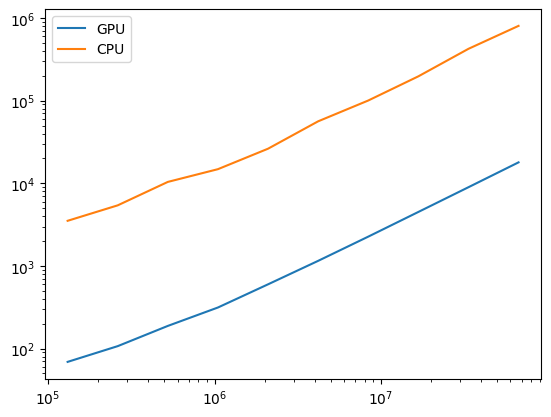

In [ ]:
import matplotlib.pyplot as plt

x = [131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864]
y_gpu = [69.00, 107.00, 188.00, 314.00, 599.00, 1152.00, 2262.00, 4500.00, 8967.00, 17928.00]
y_cpu = [3518.00, 5412.00, 10398.00, 14829.00, 26232.00, 56267.00, 100461.00, 197027.00, 424173.00, 804238.00]

plt.plot(x, y_gpu, label='GPU');
plt.plot(x, y_cpu, label='CPU');
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left")
plt.show()

# Write the GPU version of a naive 2D matrix multiplication

In [ ]:
%%writefile sgemm_naive.cu

#include <stdio.h>
#include <sys/time.h>

#define DataType double

// Compute C = A * B
// Sgemm stands for single precision general matrix-matrix multiply
__global__ void gemm(DataType *A, DataType *B, DataType *C, int numARows,
                      int numAColumns, int numBRows, int numBColumns){
  //@@ Insert code to implement matrix multiplication here
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  if (row < numARows && col < numBColumns) {
    DataType sum = 0;
    for (int ii = 0; ii < numAColumns; ii++) {
      sum += A[row * numAColumns + ii] * B[ii * numBColumns + col];
    }
    C[row * numBColumns + col] = sum;
  }
}

//@@ Insert code to implement timer
struct timeval t_start, t_end;
void myCPUTimer_start(){
  gettimeofday(&t_start, 0);
}
//@@ Insert code to implement timer
void myCPUTimer_stop(){
  cudaDeviceSynchronize();
  gettimeofday(&t_end, 0);
  double time = (1000000.0*(t_end.tv_sec-t_start.tv_sec) + t_end.tv_usec-t_start.tv_usec);
  printf("Elasped %6.1f microseconds \n", time);
}

int main(int argc, char **argv) {

  DataType *hostA; // The A matrix
  DataType *hostB; // The B matrix
  DataType *hostC; // The output C matrix
  DataType *resultRef; // The reference result
  DataType *deviceA;
  DataType *deviceB;
  DataType *deviceC;
  int numARows;    // number of rows in the matrix A
  int numAColumns; // number of columns in the matrix A
  int numBRows;    // number of rows in the matrix B
  int numBColumns; // number of columns in the matrix B
  int numCRows;
  int numCColumns;

  //@@ Insert code below to read in numARows, numAColumns, numBColumns from args
  numARows    = atoi(argv[1]);
  numAColumns = atoi(argv[2]);
  numBRows    = numAColumns;
  numBColumns = atoi(argv[3]);
  numCRows    = numARows;
  numCColumns = numBColumns;
  printf("Input matrix dim (%d x %d) (%d x %d) (%d x %d)\n", numARows, numAColumns, numBRows, numBColumns, numCRows, numCColumns);

  //@@ Insert code below to allocate Host memory for input and output
  hostA = (DataType *)malloc(numARows * numAColumns * sizeof(DataType));
  hostB = (DataType *)malloc(numBRows * numBColumns * sizeof(DataType));
  hostC = (DataType *)malloc(numCRows * numCColumns * sizeof(DataType));
  resultRef  = (DataType *)malloc(numCRows * numCColumns * sizeof(DataType));

  //@@ Insert code below to initialize hostA and hostB to random numbers, and create reference result in CPU
  for(int i=0; i<numARows; i++){
    for(int j=0; j<numAColumns; j++){
      hostA[i*numAColumns+j] = 1.0;
    }
  }
  for(int i=0; i<numBRows; i++){
    for(int j=0; j<numBColumns; j++){
      hostB[i*numBColumns+j] = 3.0;
    }
  }
  for(int i=0; i<numARows; i++){
    for(int j=0; j<numCColumns; j++){
      DataType tmp = 0;
      for(int ii=0; ii<numAColumns; ii++)
          tmp += hostA[i*numAColumns+ii] * hostB[ii*numBColumns+j];
      resultRef[i*numCColumns+j] = tmp;
    }
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc((void **)&deviceA, numARows * numAColumns * sizeof(DataType));
  cudaMalloc((void **)&deviceB, numBRows * numBColumns * sizeof(DataType));
  cudaMalloc((void **)&deviceC, numCRows * numCColumns * sizeof(DataType));

  //@@ Insert code to below to Copy memory to the GPU here
  cudaMemcpy(deviceA, hostA, numARows * numAColumns * sizeof(DataType), cudaMemcpyHostToDevice);
  cudaMemcpy(deviceB, hostB, numBRows * numBColumns * sizeof(DataType), cudaMemcpyHostToDevice);

  //@@ Initialize the grid and block dimensions here
  dim3 blockDim(16, 16);
  dim3 gridDim(ceil(((float)numCColumns) / ((float)blockDim.x)), ceil(((float)numCRows) / ((float)blockDim.y)));

  //@@ Launch the GPU Kernel here
  gemm<<<gridDim, blockDim>>>(deviceA, deviceB, deviceC, numARows,
                              numAColumns, numBRows, numBColumns);


  //@@ Copy the GPU memory back to the CPU here
  cudaMemcpy(hostC, deviceC, numCRows * numCColumns * sizeof(DataType), cudaMemcpyDeviceToHost);


  //@@ Insert code below to compare the output with the reference
  bool valid = true;
  for(int i=0; i<numCRows; i++){
    for(int j=0; j<numCColumns; j++){
      if( hostC[i*numCColumns+j] != resultRef[i*numCColumns+j] ){
        printf("hostC[%d][%d] = %f != %f\n", i,j,hostC[i*numCColumns+j],resultRef[i*numCColumns+j]);
        valid = false;
        break;
      }
    }
  }
  if(valid) printf("valid\n");

  //@@ Free the GPU memory here
  cudaFree(deviceA);
  cudaFree(deviceB);
  cudaFree(deviceC);

  //@@ Free the CPU memory here
  free(hostA);
  free(hostB);
  free(hostC);
  free(resultRef);

  return 0;
}


Writing sgemm_naive.cu


# Compile the CUDA code

In [ ]:
!nvcc -o sgemm_naive sgemm_naive.cu
!ls

dist_cpu    dist_gpu.cu  sgemm_naive.cu   vectorAdd_naive.cu
dist_cpu.c  sample_data  vectorAdd	  vectorAdd_v2.cu
dist_gpu    sgemm_naive  vectorAdd_naive


# Run the 2D matrix multiplication with different input

In [ ]:
!./sgemm_naive 128 128 128

Input matrix dim (128 x 128) (128 x 128) (128 x 128)
valid


# next, profiling with nvprof

In [ ]:
!nvprof ./sgemm_naive 128 512 512

Input matrix dim (128 x 512) (512 x 512) (128 x 512)
==12051== NVPROF is profiling process 12051, command: ./sgemm_naive 128 512 512
valid
==12051== Profiling application: ./sgemm_naive 128 512 512
==12051== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   65.22%  823.02us         1  823.02us  823.02us  823.02us  gemm(double*, double*, double*, int, int, int, int)
                   30.86%  389.43us         2  194.72us  45.695us  343.74us  [CUDA memcpy HtoD]
                    3.92%  49.407us         1  49.407us  49.407us  49.407us  [CUDA memcpy DtoH]
      API calls:   98.82%  205.10ms         3  68.366ms  3.5130us  205.02ms  cudaMalloc
                    0.98%  2.0247ms         3  674.91us  132.41us  1.2980ms  cudaMemcpy
                    0.12%  239.84us         3  79.947us  15.321us  118.01us  cudaFree
                    0.05%  112.57us       101  1.1140us     143ns  47.178us  cuDeviceGetAttribute
           

# Write a simple CUDA code that calculates histogram
# of an input array of N elements

In [ ]:
%%writefile histogram_atomic.cu

#include <stdio.h>
#include <sys/time.h>
#include <random>

#define NUM_BINS 4096

__global__ void histogram_kernel(unsigned int *input, unsigned int *bins,
                                 unsigned int num_elements,
                                 unsigned int num_bins) {

  unsigned int tid = blockIdx.x * blockDim.x + threadIdx.x;

  // Privatized bins
  extern __shared__ unsigned int bins_s[];
  for (unsigned int binIdx = threadIdx.x; binIdx < num_bins;
       binIdx += blockDim.x) {
    bins_s[binIdx] = 0;
  }
  __syncthreads();

  // Histogram
  for (unsigned int i = tid; i < num_elements; i += blockDim.x * gridDim.x) {
    atomicAdd(&(bins_s[input[i]]), 1);
  }
  __syncthreads();

  // Commit to global memory
  for (unsigned int binIdx = threadIdx.x; binIdx < num_bins;
       binIdx += blockDim.x) {
    atomicAdd(&(bins[binIdx]), bins_s[binIdx]);
  }
}

__global__ void convert_kernel(unsigned int *bins, unsigned int num_bins) {

  unsigned int tid = blockIdx.x * blockDim.x + threadIdx.x;

  if (tid < num_bins) {
    bins[tid] = min(bins[tid], 127);
  }

}


int main(int argc, char **argv) {

  int inputLength;
  unsigned int *hostInput;
  unsigned int *hostBins;
  unsigned int *resultRef;
  unsigned int *deviceInput;
  unsigned int *deviceBins;

  //@@ Insert code below to read in inputLength from args
  inputLength = atoi(argv[1]);
  printf("The input length is %d\n", inputLength);

  //@@ Insert code below to allocate Host memory for input and output
  hostInput = (unsigned int *)malloc(inputLength * sizeof(unsigned int));
  hostBins  = (unsigned int *)malloc(NUM_BINS * sizeof(unsigned int));
  resultRef = (unsigned int *)calloc(NUM_BINS, sizeof(unsigned int));

  //@@ Insert code below to initialize hostInput to random numbers whose values range from 0 to (NUM_BINS - 1)
  std::random_device rd;
  std::mt19937 gen(rd());
  std::uniform_int_distribution<> distr(0, (NUM_BINS - 1)); // define the range
  for(int i=0; i<inputLength; i++){
    hostInput[i] = distr(gen);
  }
  //@@ Insert code below to create reference result in CPU
  for(int i=0; i<inputLength; i++){
    resultRef[hostInput[i]] ++;
  }
  for(int i=0; i<NUM_BINS; i++){
    if(resultRef[i]>127) resultRef[i]=127;
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc((void **)&deviceInput, inputLength * sizeof(unsigned int));
  cudaMalloc((void **)&deviceBins, NUM_BINS * sizeof(unsigned int));

  //@@ Insert code to Copy memory to the GPU here
  cudaMemcpy(deviceInput, hostInput, inputLength * sizeof(unsigned int), cudaMemcpyHostToDevice);

  //@@ Insert code to initialize GPU results
  cudaMemset(deviceBins, 0, NUM_BINS * sizeof(unsigned int));

  //@@ Initialize the grid and block dimensions here
  dim3 blockDim1(32);
  dim3 gridDim1(ceil(((float)inputLength) / ((float)blockDim1.x)));

  //@@ Launch the GPU Kernel here
  histogram_kernel<<<gridDim1, blockDim1, NUM_BINS * sizeof(unsigned int)>>>(deviceInput, deviceBins, inputLength, NUM_BINS);

  dim3 blockDim2(32);
  dim3 gridDim2(ceil(((float)NUM_BINS) / ((float)blockDim2.x)));
  convert_kernel<<<gridDim2, blockDim2>>>(deviceBins, NUM_BINS);

  //@@ Copy the GPU memory back to the CPU here
  cudaMemcpy(hostBins, deviceBins, NUM_BINS * sizeof(unsigned int), cudaMemcpyDeviceToHost);

  //@@ Insert code below to compare the output with the reference
  bool valid = true;
  for(int i=0; i<NUM_BINS; i++){
    printf("%d, ", hostBins[i]);
    if( hostBins[i] != resultRef[i] ){
      printf("hostBins[%d] = %d != %d\n", i, hostBins[i], resultRef[i]);
      valid = false;
      break;
    }
  }
  if(valid) printf("\nvalid\n");

  //@@ Free the GPU memory here
  cudaFree(deviceInput);
  cudaFree(deviceBins);

  //@@ Free the CPU memory here
  free(hostInput);
  free(hostBins);
  free(resultRef);

  return 0;
}



Overwriting histogram_atomic.cu


In [ ]:
!nvcc -o histogram_atomic histogram_atomic.cu
!ls

histogram_atomic  histogram_atomic.cu  sample_data


# Run a batch test of histogram with 5 inputs

In [ ]:
i=0
n=4096
while i<5:
  !./histogram_atomic $n
  i=i+1
  n=n*4

The input length is 4096
2, 1, 3, 0, 1, 2, 0, 0, 1, 3, 0, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 3, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 2, 0, 1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 3, 1, 1, 4, 1, 1, 0, 1, 3, 0, 1, 1, 0, 0, 1, 3, 1, 0, 1, 1, 0, 0, 0, 1, 3, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 2, 3, 0, 1, 1, 1, 0, 0, 3, 2, 0, 0, 0, 1, 0, 2, 3, 2, 1, 0, 0, 4, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 0, 3, 0, 0, 4, 2, 1, 0, 4, 0, 1, 1, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 3, 2, 0, 2, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1, 3, 0, 1, 3, 2, 2, 3, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 1, 1, 2, 2, 3, 0, 0, 1, 1, 3, 0, 1, 1, 1, 1, 3, 2, 2, 2, 1, 1, 0, 1, 1, 0, 0, 2, 0, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, 4, 1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 3, 2, 0, 2, 

# Plot the output histogram

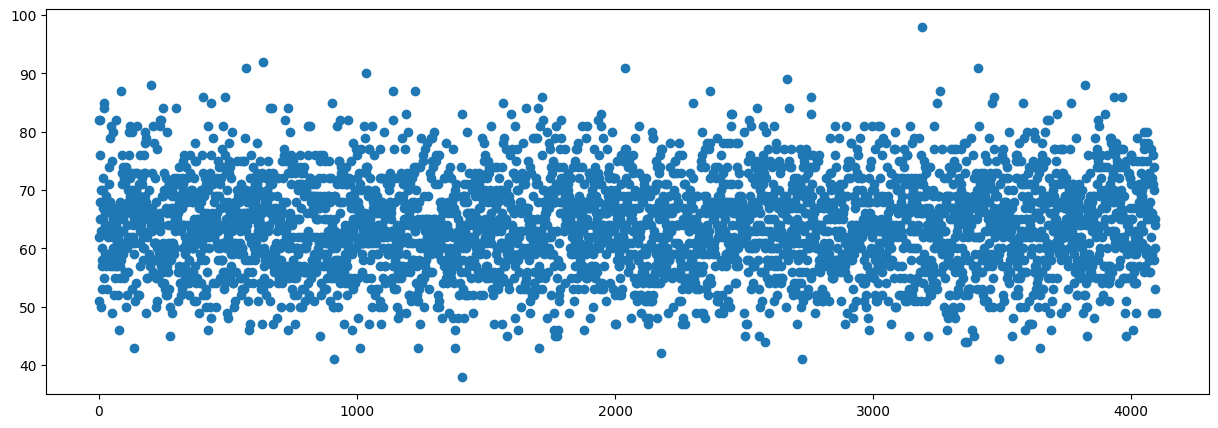

In [ ]:
import matplotlib.pyplot as plt

NUM_BINS = 4096
y = [...]
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(y,'o');
plt.show()